[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/027_pytorch_intro/pytorch_intro.ipynb)

In [1]:
lab = [
    0,1,2,3,4,5,6,7,8,9,"A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U",
    "V","W","X","Y","Z","a","b","d","e","f","g","h","n","q","r","t"
]

# Pytorch - Introducción

Hast ahora hemos implementado nuestros propios modelos de `Machine Learning` utilizando `Python` y `Numpy`. Este ejercicio nos ha servido para aprender mejor a utilizar estas herramientas de `análisis de datos` así como a conocer en gran detalle algunos de los elementos fundamentales de las redes neuronales: el [perceptrón](https://sensioai.com/blog/018_perceptron_final), el algoritmo de [descenso por gradiente](https://sensioai.com/blog/013_perceptron2), el [perceptrón multicapa](https://sensioai.com/blog/025_mlp_framework), etc. Sin embargo, de ahora en adelante, utilizaremos frameworks desarrollados por terceros. En el [post anterior](https://sensioai.com/blog/026_frameworks) hablamos en detalle de los motivos y presentamos algunos ejemplos. En este post, empezamos a aprender a trabajar con uno de los frameworks de `redes neuronales` más utilizados hoy en día: [Pytorch](https://pytorch.org/).

> ⚡ Si trabajas en Google Colab ya tendrás `Pytorch` instalado. Si quieres trabajar en local, simplemente sigue las instrucciones en https://pytorch.org/. Te recomiendo la instalación con `conda`, sobre todo si quieres soporte para GPU.

#MNIST

In [2]:
import torch
import numpy as np

In [3]:
from sklearn.datasets import fetch_openml

emnist = fetch_openml('emnist_balanced', version=1)
X, Y = emnist["data"], emnist["target"]

X.shape, Y.shape

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


((131600, 784), (131600,))

In [4]:
unique_labels = np.unique(Y)

print(unique_labels)

['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '43' '44' '45' '46' '5' '6' '7'
 '8' '9']


In [5]:
X = X.to_numpy()
Y = Y.to_numpy()

In [6]:
print(X.shape)

(131600, 784)


In [7]:
%matplotlib inline


import matplotlib as mpl
import matplotlib.pyplot as plt
import random

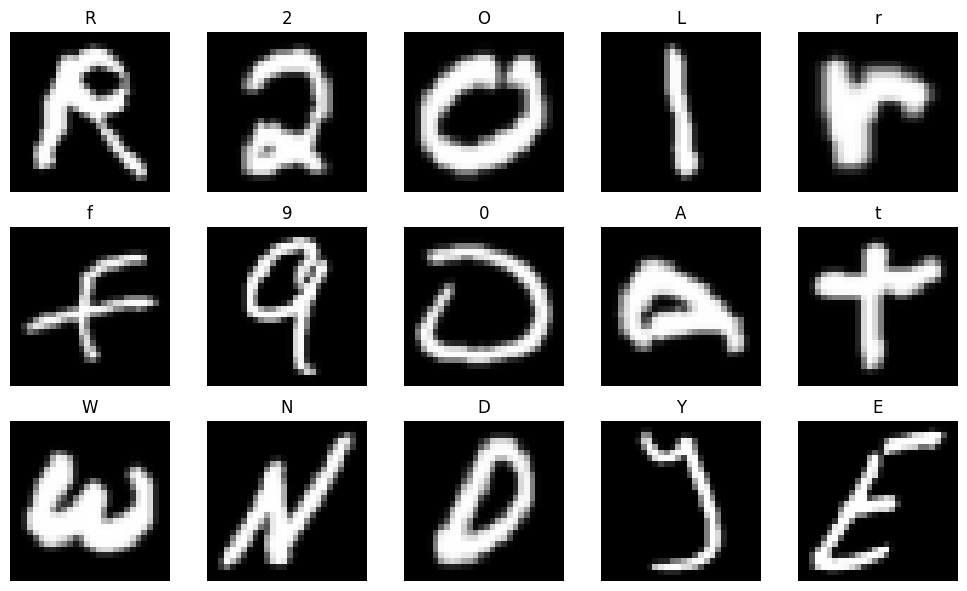

In [8]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        img = X[ix]
        img_transformed = np.rot90(np.flip(img.reshape(28, 28), axis=1), k=1)
        plt.imshow(img_transformed, cmap='gray')
        plt.axis("off")
        plt.title(lab[int(Y[ix])])
plt.tight_layout()
plt.show()

In [9]:
# normalizamos los datos

X_train, X_test, y_train, y_test = X[:121600] / 255., X[121600:] / 255., Y[:121600].astype(np.int), Y[121600:].astype(np.int)

<ipython-input-9-17d86d572d3e>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train, X_test, y_train, y_test = X[:121600] / 255., X[121600:] / 255., Y[:121600].astype(np.int), Y[121600:].astype(np.int)


In [10]:
# función de pérdida y derivada

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

In [11]:
D_in, H1, H2, D_out = 784, 500, 50, 47

# Pesos y bias para la primera capa oculta
w1 = torch.tensor(np.random.normal(loc=0.0,
          scale=np.sqrt(2/(D_in+H1)),
          size=(D_in, H1)), requires_grad=True, device="cuda", dtype=torch.float)
b1 = torch.zeros(H1, requires_grad=True, device="cuda", dtype=torch.float)

# Pesos y bias para la segunda capa oculta
w2 = torch.tensor(np.random.normal(loc=0.0,
          scale=np.sqrt(2/(H1+H2)),
          size=(H1, H2)), requires_grad=True, device="cuda", dtype=torch.float)
b2 = torch.zeros(H2, requires_grad=True, device="cuda", dtype=torch.float)

# Pesos y bias para la capa de salida
w3 = torch.tensor(np.random.normal(loc=0.0,
          scale=np.sqrt(2/(H2+D_out)),
          size=(H2, D_out)), requires_grad=True, device="cuda", dtype=torch.float)
b3 = torch.zeros(D_out, requires_grad=True, device="cuda", dtype=torch.float)

# convertimos datos a tensores y copiamos en gpu
X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(y_train).long().cuda()

epochs = 1000
lr = 0.8
log_each = 100
l = []
for e in range(1, epochs+1):

    # forward
    h1 = X_t.mm(w1) + b1
    h1_relu = h1.clamp(min=0)  # relu

    h2 = h1_relu.mm(w2) + b2
    h2_relu = h2.clamp(min=0)  # relu

    y_pred = h2_relu.mm(w3) + b3

    # loss
    loss = cross_entropy(y_pred, Y_t)
    l.append(loss.item())

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    with torch.no_grad():
        # update pesos
        w1 -= lr * w1.grad
        b1 -= lr * b1.grad
        w2 -= lr * w2.grad
        b2 -= lr * b2.grad
        w3 -= lr * w3.grad
        b3 -= lr * b3.grad

        # ponemos a cero los gradientes para la siguiente iteración
        # (sino acumularíamos gradientes)
        w1.grad.zero_()
        w2.grad.zero_()
        w3.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()
        b3.grad.zero_()

    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

Epoch 100/1000 Loss 2.02342
Epoch 200/1000 Loss 1.47805
Epoch 300/1000 Loss 1.21646
Epoch 400/1000 Loss 1.05956
Epoch 500/1000 Loss 0.95175
Epoch 600/1000 Loss 0.87150
Epoch 700/1000 Loss 0.80941
Epoch 800/1000 Loss 0.75953
Epoch 900/1000 Loss 0.71823
Epoch 1000/1000 Loss 0.68361


In [12]:
def evaluate(x):
    h1 = x.mm(w1) + b1
    h1_relu = h1.clamp(min=0)

    h2 = h1_relu.mm(w2) + b2
    h2_relu = h2.clamp(min=0)


    y_pred = h2.mm(w3) + b3  # Capa de salida (sin función de activación ya que es para regresión)
    y_probas = softmax(y_pred)

    return torch.argmax(y_probas, axis=1)

In [13]:
from sklearn.metrics import accuracy_score

y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.8184

<ipython-input-14-46a63cc8d10e>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  y_pred = evaluate(torch.tensor([img]).float().cuda())[0]


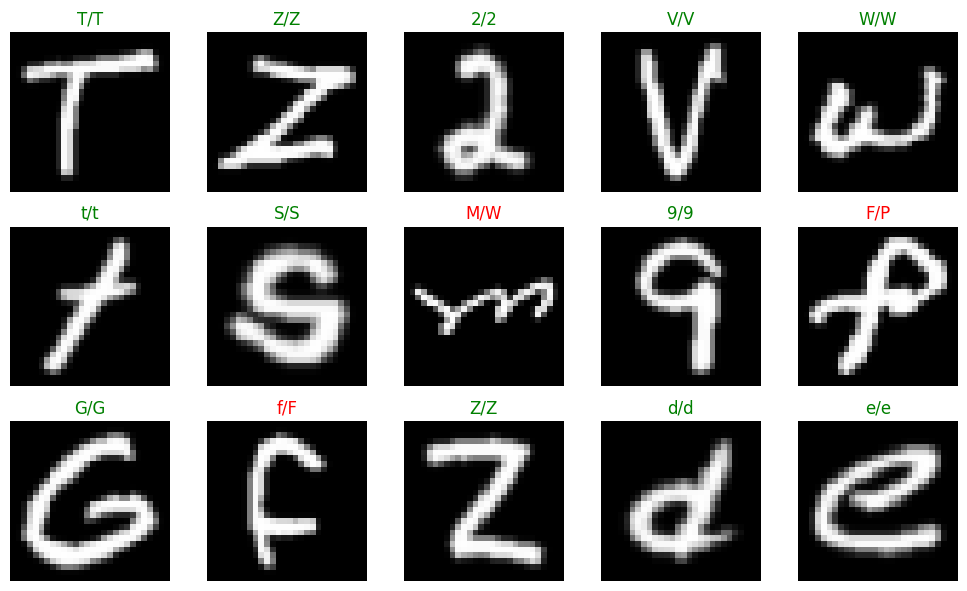

In [14]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test[ix]
        y_pred = evaluate(torch.tensor([img]).float().cuda())[0]

        img_transformed = np.rot90(np.flip(img.reshape(28, 28), axis=1), k=1)
        plt.imshow(img_transformed, cmap='gray')
        plt.axis("off")
        plt.title(f"{lab[int(y_test[ix])]}/{lab[int(y_pred)]}", color="green" if y_test[ix] == y_pred else "red")
plt.tight_layout()
plt.show()

Como puedes observar, simplemente definiendo los `tensores` para los pesos y los datos y copiándolos a la GPU podemos definir el `grafo computacional` de manera dinámica aplicando operaciones sobre los tensores (multiplicamos por los pesos y sumamos el *bias*). Una vez tenemos la salida del `MLP` calculamos la función de pérdida y llamando a la función `backward` `Pytorch` se encarga de calcular todas las derivadas de manera automática. Una vez tenemos los gradientes con respecto a los pesos, podemos actualizarlos.

## Resumen

En este post hemos visto una introducción a `Pytorch`, un framework de `redes neuronales` muy utilizado a día de hoy. Hemos visto que `Pytorch` es muy similar a `NumPy` y comparten gran parte de su sintaxis, lo cual es una ventaja si ya sabemos trabajar con `NumPy`. Además, añade `autograd`, la capacidad de construir de manera dinámica un `grafo computacional` de manera que en cualquier momento podemos calcular derivadas con respecto a cualquier tensor de manera automática. Por último, hemos visto como podemos ejecutar todas estas operaciones en una GPU para acelerar el proceso de entrenamiento de nuestros modelos de `Deep Learning`. Este es el núcleo de `Pytorch`, sin embargo esta librería nos ofrece más funcionalidad, de la cual hablaremos más adelante, que nos será muy útil para diseñar, entrenar y poner a trabajar nuestras `redes neuronales`.